In [1]:
assay_index = 11

In [2]:
import pandas as pd
!gsutil cp gs://chem_dsrc/P0_Toxcast/Data/assay_df/*_df.csv ./

Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/335_all_assay_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NCCT_TPO_AUR_dn_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP1A2_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP2B6_df.csv...
/ [4 files][  4.3 MiB/  4.3 MiB]                                                
Operation completed over 4 objects/4.3 MiB.                                      


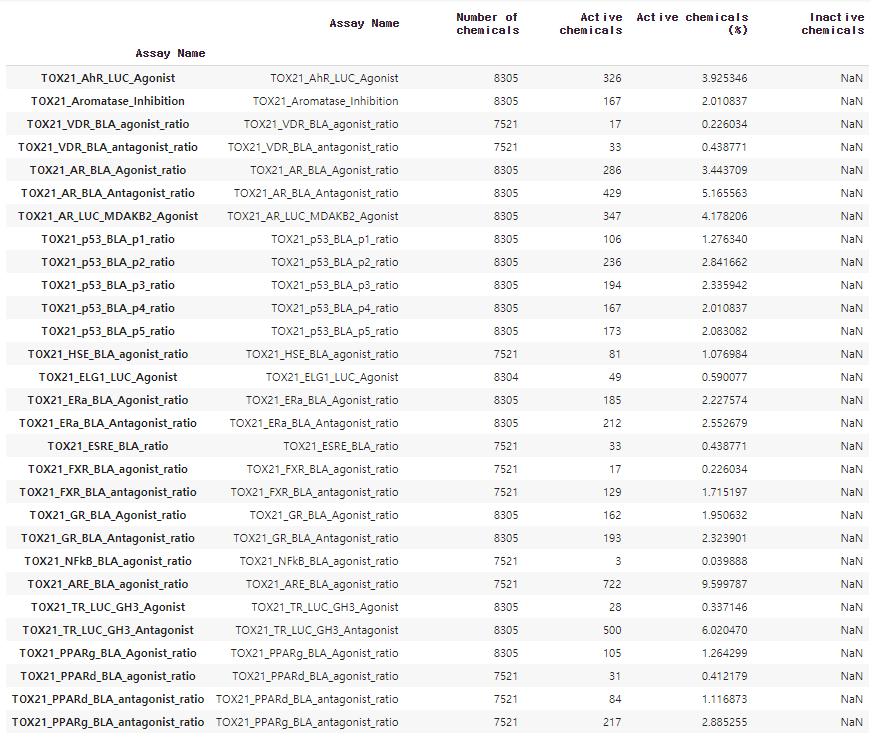

In [3]:
selected_assay_list = ['TOX21_AhR_LUC_Agonist', 'TOX21_Aromatase_Inhibition', 'TOX21_VDR_BLA_agonist_ratio', 'TOX21_VDR_BLA_antagonist_ratio', 'TOX21_AR_BLA_Agonist_ratio', 'TOX21_AR_BLA_Antagonist_ratio', 'TOX21_AR_LUC_MDAKB2_Agonist', 'TOX21_p53_BLA_p1_ratio', 'TOX21_p53_BLA_p2_ratio', 'TOX21_p53_BLA_p3_ratio', 'TOX21_p53_BLA_p4_ratio', 'TOX21_p53_BLA_p5_ratio', 'TOX21_HSE_BLA_agonist_ratio', 'TOX21_ELG1_LUC_Agonist', 'TOX21_ERa_BLA_Agonist_ratio', 'TOX21_ERa_BLA_Antagonist_ratio', 'TOX21_ESRE_BLA_ratio', 'TOX21_FXR_BLA_agonist_ratio', 'TOX21_FXR_BLA_antagonist_ratio', 'TOX21_GR_BLA_Agonist_ratio', 'TOX21_GR_BLA_Antagonist_ratio', 'TOX21_NFkB_BLA_agonist_ratio', 'TOX21_ARE_BLA_agonist_ratio', 'TOX21_TR_LUC_GH3_Agonist', 'TOX21_TR_LUC_GH3_Antagonist', 'TOX21_PPARg_BLA_Agonist_ratio', 'TOX21_PPARd_BLA_agonist_ratio', 'TOX21_PPARd_BLA_antagonist_ratio', 'TOX21_PPARg_BLA_antagonist_ratio']

In [4]:
selected_assay_list.remove('TOX21_NFkB_BLA_agonist_ratio') #active물질 개수가 3개뿐인 assay라 모델 

In [5]:
assay_name = '335_all_assay'
df = pd.read_csv(assay_name+"_df.csv")

In [6]:
df

,Unnamed: 0,TOX21_AhR_LUC_Agonist,smiles,TOX21_Aromatase_Inhibition,TOX21_VDR_BLA_agonist_ratio,TOX21_VDR_BLA_antagonist_ratio,ATG_Ahr_CIS_up,NVS_ADME_hCYP2C19,NVS_ADME_hCYP19A1,NVS_ADME_hCYP2C9,NVS_ADME_hCYP1A1,NVS_ADME_hCYP1A2,NVS_ADME_hCYP3A4,NVS_ADME_hCYP2B6,NVS_ADME_hCYP2D6,NVS_ADME_hCYP2A6,NVS_ADME_hCYP4F12,NVS_ADME_rCYP2C12,TOX21_AR_BLA_Agonist_ratio,TOX21_AR_BLA_Antagonist_ratio,TOX21_AR_LUC_MDAKB2_Agonist,ATG_AR_TRANS_up,OT_AR_ARELUC_AG_1440,OT_AR_ARSRC1_0480,OT_AR_ARSRC1_0960,NVS_NR_rAR,NVS_NR_hAR,TOX21_p53_BLA_p1_ratio,TOX21_p53_BLA_p2_ratio,TOX21_p53_BLA_p3_ratio,TOX21_p53_BLA_p4_ratio,TOX21_p53_BLA_p5_ratio,TOX21_HSE_BLA_agonist_ratio,TOX21_ELG1_LUC_Agonist,ATG_p53_CIS_up,ATG_E2F_CIS_up,ATG_HSE_CIS_up,ATG_Myb_CIS_up,ATG_Myc_CIS_up,BSK_BE3C_uPA_down,...,NVS_GPCR_rAdra1B,NVS_GPCR_r5HT_NonSelective,NVS_GPCR_r5HT1_NonSelective,NVS_GPCR_hAdra2A,NVS_GPCR_hH1,NVS_ENZ_hPTPN11,NVS_GPCR_hAdoRA2a,NVS_GPCR_hAdrb3,NVS_GPCR_rNK3,NVS_LGIC_rNNR_BungSens,NVS_GPCR_hM1,NVS_ENZ_hPDE10,NVS_ENZ_hPTPN12,NVS_GPCR_rAdra2_NonSelective,NVS_GPCR_hAdrb2,NVS_GPCR_hDRD4.4,NVS_TR_rNET,NVS_TR_hAdoT,NVS_ENZ_hPTPN13,NVS_GPCR_rSST,NVS_GPCR_hLTB4_BLT1,NVS_GPCR_hAT1,NVS_LGIC_bGABARa1,NVS_LGIC_h5HT3,NVS_GPCR_rAdrb_NonSelective,NVS_ENZ_hTrkA,NVS_LGIC_rGABAR_NonSelective,NVS_GPCR_bDR_NonSelective,NVS_GPCR_rV1,NVS_LGIC_hNNR_NBungSens,TOX21_PPARg_BLA_Agonist_ratio,TOX21_PPARd_BLA_agonist_ratio,TOX21_PPARd_BLA_antagonist_ratio,TOX21_PPARg_BLA_antagonist_ratio,ATG_PPARa_TRANS_up,ATG_PPRE_CIS_up,ATG_PPARd_TRANS_up,ATG_PPARg_TRANS_up,NVS_NR_hPPARg,NVS_NR_hPPARa
0,100-00-5,N,[O-][N+](=O)C1=CC=C(Cl)C=C1,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,...,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,N,NaN
1,1000-05-1,N,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,NaN,NaN
2,10001-13-5,N,CN1CCN(CC1)C(=O)C1CCCCC1,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN
3,100-01-6,N,NC1=CC=C(C=C1)[N+]([O-])=O,N,N,N,N,6.449239794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.086069804,NaN,NaN,N,N,N,N,N,N,N,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,NaN,NaN
4,100-02-7,N,OC1=CC=C(C=C1)[N+]([O-])=O,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,N,N,N,NaN,NaN,0.000103442,N,0.000122936,N,N,N,N,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9219,NOCAS_903892,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,NaN,NaN
9220,NOCAS_903893,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
ss = selected_assay_list[assay_index] # 그룹
a_i = 0 # assay index
ffpp = "maccs"

In [8]:
# rdkit 2020.03.3 버전 다운로드
!pip install kora -q
import kora.install.rdkit
!pip install pycaret
from pycaret.classification import *
import numpy
import pandas
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 266kB 5.7MB/s 
     |████████████████████████████████| 276kB 7.4MB/s 
     |████████████████████████████████| 14.2MB 154kB/s 
     |████████████████████████████████| 1.7MB 46.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 102kB 8.7MB/s 
     |████████████████████████████████| 245kB 34.7MB/s 
     |████████████████████████████████| 2.0MB 30.9MB/s 
     |████████████████████████████████| 6.8MB 34.9MB/s 
     |████████████████████████████████| 215kB 44.2MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 1.1MB 34.2MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
    

In [9]:
from pycaret.utils import enable_colab
enable_colab() #to display interactive visuals.

Colab mode enabled.


In [10]:
df_ss = df.loc[:,['smiles',ss]]
df_ss = df_ss.dropna()

In [11]:
assays_ss = df_ss.columns

In [12]:
assays_ss

Index(['smiles', 'TOX21_p53_BLA_p5_ratio'], dtype='object')

In [13]:
from imblearn.combine import SMOTEENN 
sme = SMOTEENN(random_state=42,sampling_strategy = "minority")

In [14]:
ss

'TOX21_p53_BLA_p5_ratio'

In [15]:
#Smiles --> MACCS Keys
assay = ss
df_train  = df_ss[['smiles',ss] ]

smiles_list = []
err_smiles = []# fingerfrint로 변환시 에러 smiles
fps = []
enc_y = []
for index, row in df_train.iterrows():

  if row[-1] == 'N' : 
    target = 0
  else :
    target = 1

  try : 
    mol = Chem.MolFromSmiles(row['smiles'])
    
    if ffpp == 'maccs' :    
        fp = MACCSkeys.GenMACCSKeys(mol)
    elif ffpp == 'morgan' : 
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    elif ffpp == 'rdkit' : 
        fp = Chem.RDKFingerprint(mol)
    elif ffpp == 'pattern' : 
        fp = Chem.rdmolops.PatternFingerprint(mol)
    elif ffpp == 'layerd' : 
        fp = Chem.rdmolops.LayeredFingerprint(mol)
    else : 
        print("fingerfrint selection error!")
        
    smiles_list.append(row['smiles'])   
    fps.append(fp)
    enc_y.append(target)
  except : 
    err_smiles.append(row['smiles'])
    pass

np_fps = []
for fp in fps:
  arr = numpy.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  np_fps.append(arr)

np_fps_array = numpy.array(np_fps)

print("변환 에러난 smiles 개수 : ", len(err_smiles), err_smiles)

x_train_res, y_train_res = np_fps_array, np.array(enc_y)
train = pd.DataFrame(data=x_train_res)
train['label'] = y_train_res

변환 에러난 smiles 개수 :  9 ['[F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1', 'CC1C=C[C-](=C1)[Mn+]([C-]#[O+])([C-]#[O+])[C-]#[O+]', '[H][O]1[Au+][S-]C2O[C@H](CO)[C@@H](O)[C@H](O)[C@@]12[H]', '[O-]1N2C=CC=CC2=[S][Zn++]11[O-]N2C=CC=CC2=[S]1', '[H][N]([H])([H])[Pt++]([Cl-])([Cl-])[N]([H])([H])[H]', '[Na+].[Na+].F[Si--](F)(F)(F)(F)F', '[NH4+].[NH4+].F[Si--](F)(F)(F)(F)F', '[H][N]([H])([H])[Pt++]1([O-]C(=O)C2(CCC2)C(=O)[O-]1)[N]([H])([H])[H]', 'C[Sn](C)(|[O]C(=O)CCCCCC(C)(C)C)|[O]C(=O)CCCCCC(C)(C)C']


In [16]:
d = pd.DataFrame(columns = ['smiles','Type'] )
d['smiles'] = smiles_list
d['Type'] = enc_y

In [17]:
d

,smiles,Type
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,0
2,CN1CCN(CC1)C(=O)C1CCCCC1,0
3,NC1=CC=C(C=C1)[N+]([O-])=O,0
4,OC1=CC=C(C=C1)[N+]([O-])=O,0
...,...,...
8131,FC1=CC(Br)=C(C=C1)C(=O)NS(=O)(=O)\C=C\C1=CC=CS1,0
8132,OC(=O)C(F)(F)F.CCN(CC)C(=O)C1=C(C=C(N2CCC(CC2)...,0
8133,NC1=CC=C(C(O)=O)C(O)=C1.CN(C)CCOC1=CC=CC=C1CC1...,0
8134,CC(=O)NC1=NC(=O)N(C=C1)C1COC(COC(=O)C2=CC=CC=C...,0


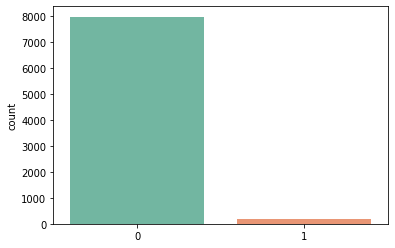

In [18]:
import seaborn as sns
sns.countplot(enc_y, palette="Set2") #팔레트를 이렇게 바꿀수 있구나.

In [19]:
#모든 물질에 대한 fingerprint를 string형태로 바꾼다(비교하기위함).
mychems = []
for item in np_fps:
    #print(item)
    item = np.array(item,dtype=int) #왜 굳이 두번? int형으로 추가하려면 이렇게 하면 되는구나....
    s = item.tolist() #넘파이어레이를 리스트로 바꾼다. 
    t = [str(i) for i in s]
    mychems.append(''.join(t))

In [20]:
i = 0
counter = 0
chemdict = {} #딗셔너리.
listofdups = []
for item in mychems:
    try:
        chemdict[str(item)].append(i)
        #print('dup found')
        for j in range(len(chemdict[str(item)])):
            if (d['Type'][i] != d['Type'][chemdict[str(item)][j]]) :
                listofdups.append(i)
                counter+=1
    except: 
        #print('adding new')
        chemdict[str(item)] = []
        chemdict[str(item)].append(i)
    i+=1
print(str(counter)+' '+str(len(list(set(listofdups)))))
#smote적용하기 전에서 listofdups를 빼면 된다!


84 60


In [21]:
dups_list = list(set(listofdups))

In [22]:
dups_list # 0인것만 지우는게 맞나?

[3968,
 3587,
 3588,
 7299,
 2567,
 2823,
 4616,
 5385,
 7433,
 7563,
 3088,
 7442,
 2836,
 2837,
 2838,
 7828,
 7833,
 2586,
 7715,
 1956,
 7716,
 7850,
 7468,
 7856,
 3505,
 4530,
 7730,
 5431,
 7863,
 7864,
 5309,
 7613,
 7359,
 1600,
 3139,
 7417,
 5960,
 5450,
 7628,
 1101,
 5709,
 79,
 6349,
 5718,
 7421,
 6234,
 2791,
 5991,
 5993,
 7401,
 8043,
 6638,
 3824,
 1777,
 4979,
 7797,
 7415,
 5497,
 6267,
 4989]

In [23]:
dups_list_0 = []
for index in dups_list : 
  if train.iloc[index].label == 0 :
    dups_list_0.append(index)

In [24]:
train = train.drop(dups_list_0)

In [25]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [26]:
len(smiles_list)

8136

In [27]:
duplicated_smiles_0_df = pd.DataFrame()
duplicated_smiles_0_df['deleted_duplicate_smiles_0'] = smiles_list
duplicated_smiles_0_df = duplicated_smiles_0_df.iloc[dups_list_0,]
duplicated_smiles_0_df

,deleted_duplicate_smiles_0
3968,F[P-](F)(F)(F)(F)F.CCCCCCCCCCN1C=C[N+](C)=C1
3587,F[P-](F)(F)(F)(F)F.CCCCCCN1C=C[N+](C)=C1
3588,F[P-](F)(F)(F)(F)F.CCCCCCCCN1C=C[N+](C)=C1
7299,C1=CC2=C(C=C1)C1=C(C=CC=C1)C=C2
2823,C1=CC2=C(C=C1)C1=C(C=C2)C2=C(C=CC=C2)C=C1
5385,OC1=CC=CC(Cl)=C1Cl
7433,OC1=C(Cl)C(Cl)=C(Cl)C(Cl)=C1Cl
7563,CC1=C2C=CC=CC2=CC=C1
3088,C[C@@H](CN1CC(=O)NC(=O)C1)N1CC(=O)NC(=O)C1
7442,OC1=C(Cl)C=C(Cl)C=C1Cl


In [28]:
save_path = 'gs://chem_dsrc/P0_Toxcast/result/29assays_dd/'

In [29]:
dupdf = ss+"_dup_smiles_df.csv"
duplicated_smiles_0_df.to_csv(dupdf)
duppath = save_path + 'err_smiles/'
!gsutil cp $dupdf $duppath

Copying file://TOX21_p53_BLA_p5_ratio_dup_smiles_df.csv [Content-Type=text/csv]...
/ [1 files][  2.0 KiB/  2.0 KiB]                                                
Operation completed over 1 objects/2.0 KiB.                                      


In [30]:
import pandas as pd
err_smiles_df = pd.DataFrame(columns = [ss], index = ['err_n','err_smiles'])
err_smiles_df[ss] = [ len(err_smiles), err_smiles]

In [31]:
ersdf = ss+"_err_smiles_df.csv"
err_smiles_df.to_csv(ersdf)
errpath = save_path + 'err_smiles/'
!gsutil cp $ersdf $errpath $errpath

Copying file://TOX21_p53_BLA_p5_ratio_err_smiles_df.csv [Content-Type=text/csv]...
Omitting prefix "gs://chem_dsrc/P0_Toxcast/result/29assays_dd/err_smiles/". (Did you mean to do cp -r?)

Operation completed over 1 objects/515.0 B.                                      


In [32]:
err_smiles_df

,TOX21_p53_BLA_p5_ratio
err_n,9
err_smiles,"[[F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1, CC..."


In [33]:
# clf = setup(data = train, target = 'label') 
clf = setup(data = train, target = 'label', fix_imbalance = True, fix_imbalance_method = sme
            ,train_size = 0.9
            ,use_gpu =True
            ,session_id=123) 

,Description,Value
0,session_id,123
1,Target,label
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(8093, 168)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,163
8,Ordinal Features,False
9,High Cardinality Features,False


# RF - default parameter

In [34]:
save_path_m = save_path+'/rf/'

In [ ]:
rf = create_model('rf')
rf_df = pull()
rf_df_name = "rf_df_"+ss+".csv"
rf_df.to_csv(rf_df_name)
rf_df_path = save_path_m+ss+"/"
!gsutil cp $rf_df_name $rf_df_path

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9698,0.5934,0.0000,0.0000,0.0000,-0.0121,-0.0136
1,0.9739,0.5824,0.1250,0.2857,0.1739,0.1627,0.1773
2,0.9698,0.6248,0.1250,0.2000,0.1538,0.1393,0.1433
3,0.9780,0.6211,0.1333,0.4000,0.2000,0.1917,0.2221
4,0.9725,0.4396,0.1333,0.2222,0.1667,0.1536,0.1588
5,0.9725,0.6657,0.2000,0.2727,0.2308,0.2171,0.2198
6,0.9684,0.7318,0.1333,0.1667,0.1481,0.1323,0.1331
7,0.9684,0.6847,0.0667,0.1000,0.0800,0.0646,0.0660
8,0.9684,0.5740,0.0667,0.1000,0.0800,0.0646,0.0660
9,0.9739,0.4577,0.0000,0.0000,0.0000,-0.0088,-0.0108


Copying file://rf_df_TOX21_p53_BLA_p5_ratio.csv [Content-Type=text/csv]...
/ [1 files][  613.0 B/  613.0 B]                                                
Operation completed over 1 objects/613.0 B.                                      


In [ ]:
predict_model(rf)
rf_p_df = pull()
rf_p_df_name = "rf_p_df_"+ss+".csv"
rf_p_df.to_csv(rf_p_df_name)
rf_p_df_path = save_path_m+ss+"/"
!gsutil cp $rf_p_df_name $rf_p_df_path

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9728,0.7629,0.0,0.0,0.0,-0.0096,-0.0115


Copying file://rf_p_df_TOX21_p53_BLA_p5_ratio.csv [Content-Type=text/csv]...
/ [1 files][  115.0 B/  115.0 B]                                                
Operation completed over 1 objects/115.0 B.                                      


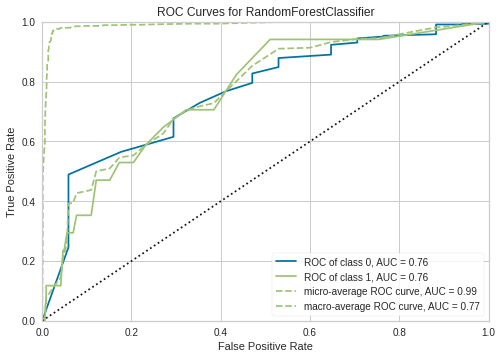

In [ ]:
plot_model(rf, plot = 'auc')

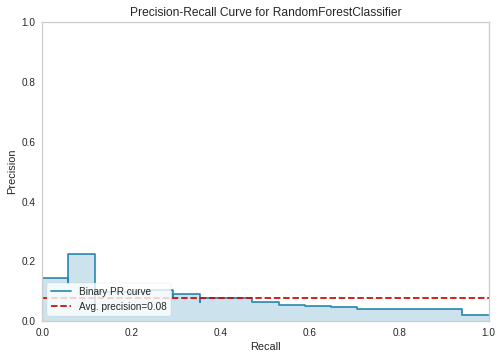

In [ ]:
plot_model(rf, plot = 'pr')

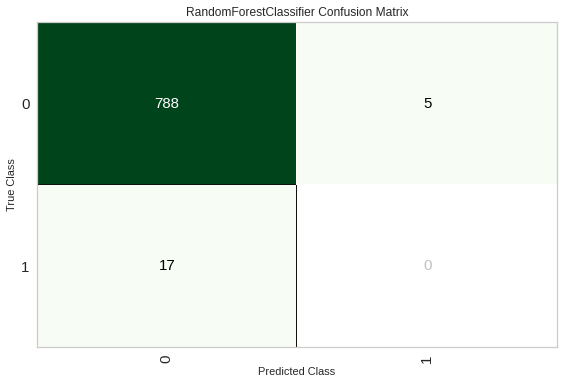

In [ ]:
plot_model(rf, plot = 'confusion_matrix')

In [ ]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


# RF - tuned parameter by AUC

In [ ]:
tuned_rf_auc = tune_model(rf, optimize = 'AUC')
tuned_rf_auc_df = pull()
tuned_rf_auc_df_name = "tuned_rf_auc_df_"+ss+".csv"
tuned_rf_auc_df.to_csv(tuned_rf_auc_df_name)
tuned_rf_auc_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_df_name $tuned_rf_auc_df_path

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8793,0.7163,0.0625,0.0135,0.0222,-0.0144,-0.0193
1,0.8354,0.4890,0.1250,0.0185,0.0323,-0.0062,-0.0098
2,0.8765,0.7094,0.5000,0.0889,0.1509,0.1181,0.1715
3,0.8420,0.6140,0.3333,0.0455,0.0800,0.0454,0.0738
4,0.8393,0.5345,0.2667,0.0364,0.0640,0.0288,0.0468
5,0.8681,0.6469,0.3333,0.0549,0.0943,0.0611,0.0914
6,0.8668,0.6939,0.4667,0.0729,0.1261,0.0938,0.1435
7,0.8942,0.7092,0.3333,0.0694,0.1149,0.0837,0.1139
8,0.8695,0.6408,0.3333,0.0556,0.0952,0.0621,0.0924
9,0.8626,0.4690,0.0667,0.0115,0.0196,-0.0161,-0.0236


Copying file://tuned_rf_auc_df_TOX21_p53_BLA_p5_ratio.csv [Content-Type=text/csv]...
/ [1 files][  648.0 B/  648.0 B]                                                
Operation completed over 1 objects/648.0 B.                                      


In [ ]:
predict_model(tuned_rf_auc)
tuned_rf_auc_p_df = pull()
tuned_rf_auc_p_df_name = "tuned_rf_auc_p_df_"+ss+".csv"
tuned_rf_auc_p_df.to_csv(tuned_rf_auc_p_df_name)
tuned_rf_auc_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_p_df_name $tuned_rf_auc_p_df_path

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8457,0.6513,0.2941,0.0424,0.0741,0.0388,0.0616


Copying file://tuned_rf_auc_p_df_TOX21_p53_BLA_p5_ratio.csv [Content-Type=text/csv]...
/ [1 files][  122.0 B/  122.0 B]                                                
Operation completed over 1 objects/122.0 B.                                      


# RF -tuned parameter by F1

In [ ]:
tuned_rf_f1 = tune_model(rf, optimize = 'F1')
tuned_rf_f1_df = pull()
tuned_rf_f1_df_name = "tuned_rf_f1_df_"+ss+".csv"
tuned_rf_f1_df.to_csv(tuned_rf_f1_df_name)
tuned_rf_f1_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_df_name $tuned_rf_f1_df_path

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9232,0.6511,0.1250,0.0455,0.0667,0.0356,0.0407
1,0.9150,0.4989,0.2500,0.0741,0.1143,0.0832,0.1006
2,0.9383,0.7083,0.3125,0.1282,0.1818,0.1555,0.1724
3,0.9148,0.5776,0.3333,0.0877,0.1389,0.1098,0.1377
4,0.9066,0.5475,0.2000,0.0508,0.0811,0.0499,0.0632
5,0.9258,0.6574,0.2000,0.0667,0.1000,0.0713,0.0832
6,0.9148,0.6759,0.4000,0.1017,0.1622,0.1337,0.1695
7,0.9327,0.6899,0.2667,0.0952,0.1404,0.1134,0.1300
8,0.9272,0.6525,0.2667,0.0870,0.1311,0.1033,0.1213
9,0.8997,0.4352,0.0667,0.0167,0.0267,-0.0065,-0.0083


Copying file://tuned_rf_f1_df_TOX21_p53_BLA_p5_ratio.csv [Content-Type=text/csv]...
/ [1 files][  637.0 B/  637.0 B]                                                
Operation completed over 1 objects/637.0 B.                                      


In [ ]:
predict_model(tuned_rf_f1)
tuned_rf_f1_p_df = pull()
tuned_rf_f1_p_df_name = "tuned_rf_f1_p_df_"+ss+".csv"
tuned_rf_f1_p_df.to_csv(tuned_rf_f1_p_df_name)
tuned_rf_f1_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_p_df_name $tuned_rf_f1_p_df_path

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9136,0.6337,0.2941,0.0794,0.125,0.0951,0.1183


Copying file://tuned_rf_f1_p_df_TOX21_p53_BLA_p5_ratio.csv [Content-Type=text/csv]...
/ [1 files][  121.0 B/  121.0 B]                                                
Operation completed over 1 objects/121.0 B.                                      


# RF -tuned parameter by Kappa

In [ ]:
tuned_rf_kappa = tune_model(rf, optimize = 'Kappa')
tuned_rf_kappa_df = pull()
tuned_rf_kappa_df_name = "tuned_rf_kappa_df_"+ss+".csv"
tuned_rf_kappa_df.to_csv(tuned_rf_kappa_df_name)
tuned_rf_kappa_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_df_name $tuned_rf_kappa_df_path

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9232,0.6511,0.1250,0.0455,0.0667,0.0356,0.0407
1,0.9150,0.4989,0.2500,0.0741,0.1143,0.0832,0.1006
2,0.9383,0.7083,0.3125,0.1282,0.1818,0.1555,0.1724
3,0.9148,0.5776,0.3333,0.0877,0.1389,0.1098,0.1377
4,0.9066,0.5475,0.2000,0.0508,0.0811,0.0499,0.0632
5,0.9258,0.6574,0.2000,0.0667,0.1000,0.0713,0.0832
6,0.9148,0.6759,0.4000,0.1017,0.1622,0.1337,0.1695
7,0.9327,0.6899,0.2667,0.0952,0.1404,0.1134,0.1300
8,0.9272,0.6525,0.2667,0.0870,0.1311,0.1033,0.1213
9,0.8997,0.4352,0.0667,0.0167,0.0267,-0.0065,-0.0083


Copying file://tuned_rf_kappa_df_TOX21_p53_BLA_p5_ratio.csv [Content-Type=text/csv]...
/ [1 files][  637.0 B/  637.0 B]                                                
Operation completed over 1 objects/637.0 B.                                      


In [ ]:
predict_model(tuned_rf_kappa)
tuned_rf_kappa_p_df = pull()
tuned_rf_kappa_p_df_name = "tuned_rf_kappa_p_df_"+ss+".csv"
tuned_rf_kappa_p_df.to_csv(tuned_rf_kappa_p_df_name)
tuned_rf_kappa_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_p_df_name $tuned_rf_kappa_p_df_path

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9136,0.6337,0.2941,0.0794,0.125,0.0951,0.1183


Copying file://tuned_rf_kappa_p_df_TOX21_p53_BLA_p5_ratio.csv [Content-Type=text/csv]...
/ [1 files][  121.0 B/  121.0 B]                                                
Operation completed over 1 objects/121.0 B.                                      


# RF -tuned parameter by MCC

In [ ]:
tuned_rf_MCC = tune_model(rf, optimize = 'MCC')
tuned_rf_MCC_df = pull()
tuned_rf_MCC_df_name = "tuned_rf_MCC_df_"+ss+".csv"
tuned_rf_MCC_df.to_csv(tuned_rf_MCC_df_name)
tuned_rf_MCC_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_df_name $tuned_rf_MCC_df_path

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9232,0.6511,0.1250,0.0455,0.0667,0.0356,0.0407
1,0.9150,0.4989,0.2500,0.0741,0.1143,0.0832,0.1006
2,0.9383,0.7083,0.3125,0.1282,0.1818,0.1555,0.1724
3,0.9148,0.5776,0.3333,0.0877,0.1389,0.1098,0.1377
4,0.9066,0.5475,0.2000,0.0508,0.0811,0.0499,0.0632
5,0.9258,0.6574,0.2000,0.0667,0.1000,0.0713,0.0832
6,0.9148,0.6759,0.4000,0.1017,0.1622,0.1337,0.1695
7,0.9327,0.6899,0.2667,0.0952,0.1404,0.1134,0.1300
8,0.9272,0.6525,0.2667,0.0870,0.1311,0.1033,0.1213
9,0.8997,0.4352,0.0667,0.0167,0.0267,-0.0065,-0.0083


Copying file://tuned_rf_MCC_df_TOX21_p53_BLA_p5_ratio.csv [Content-Type=text/csv]...
/ [1 files][  637.0 B/  637.0 B]                                                
Operation completed over 1 objects/637.0 B.                                      


In [ ]:
predict_model(tuned_rf_MCC)
tuned_rf_MCC_p_df = pull()
tuned_rf_MCC_p_df_name = "tuned_rf_MCC_p_df_"+ss+".csv"
tuned_rf_MCC_p_df.to_csv(tuned_rf_MCC_p_df_name)
tuned_rf_MCC_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_p_df_name $tuned_rf_MCC_p_df_path

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9136,0.6337,0.2941,0.0794,0.125,0.0951,0.1183


Copying file://tuned_rf_MCC_p_df_TOX21_p53_BLA_p5_ratio.csv [Content-Type=text/csv]...
/ [1 files][  121.0 B/  121.0 B]                                                
Operation completed over 1 objects/121.0 B.                                      


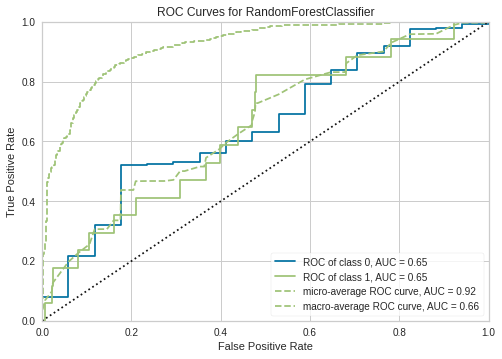

In [ ]:
plot_model(tuned_rf_auc, plot = 'auc')

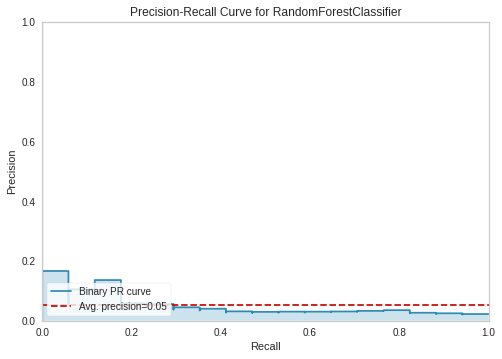

In [ ]:
plot_model(tuned_rf_auc, plot = 'pr')

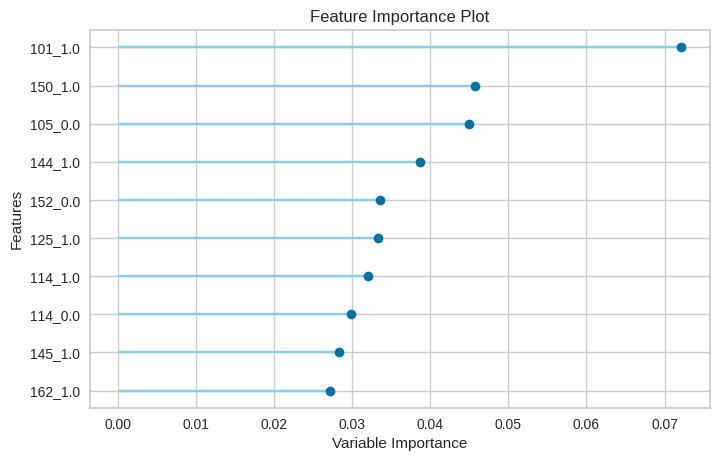

In [ ]:
plot_model(tuned_rf_auc, plot='feature')

In [ ]:
print(tuned_rf_auc)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0005,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


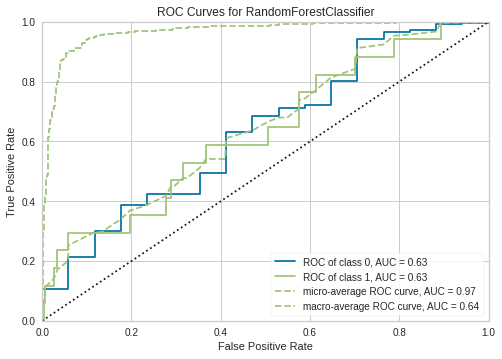

In [ ]:
plot_model(tuned_rf_f1, plot = 'auc')

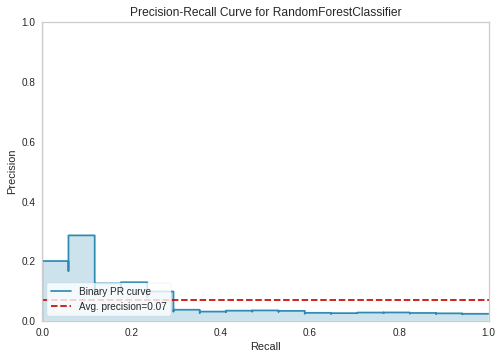

In [ ]:
plot_model(tuned_rf_f1, plot = 'pr')

In [ ]:
plot_model(tuned_rf_f1, plot='feature')

In [ ]:
print(tuned_rf_f1)

In [ ]:
plot_model(tuned_rf_kappa, plot = 'auc')

In [ ]:
plot_model(tuned_rf_kappa, plot = 'pr')

In [ ]:
plot_model(tuned_rf_kappa, plot='feature')

In [ ]:
print(tuned_rf_kappa)

In [ ]:
plot_model(tuned_rf_MCC, plot = 'auc')

In [ ]:
plot_model(tuned_rf_MCC, plot = 'pr')

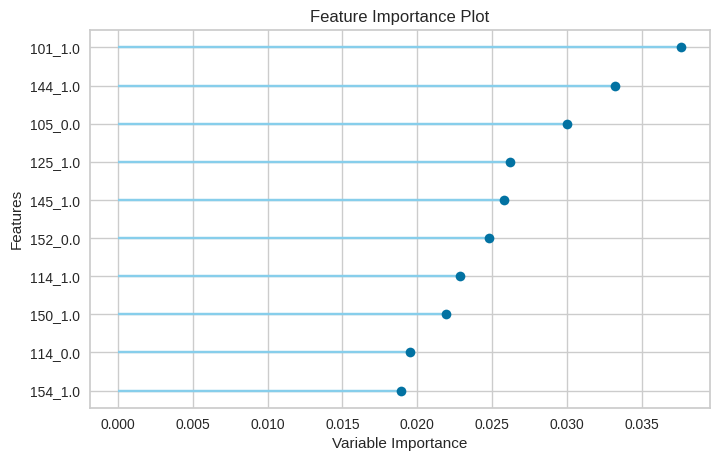

In [ ]:
plot_model(tuned_rf_MCC, plot='feature')

In [ ]:
print(tuned_rf_MCC)

# all algorithm compare with validation auc

In [ ]:
best_specific = compare_models (sort = 'AUC', n_select = 6)
allml_df = pull()
allml_df_name = "allml_df_"+ss+".csv"
allml_df.to_csv(allml_df_name)
allml_df_path save_path+"allml/"+ss+"/"
!gsutil cp $allml_df_name $allml_df_path